# MNIST handwritten digits classification with MLPs

In this notebook, we'll train a multi-layer perceptron model to classify MNIST digits using **PyTorch**. 

First, the needed imports. 

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.13.1+cpu  Device: cpu


## Data

Next we'll load the MNIST data.  First time we may have to download the data, which can take a while.

Note that we are here using the MNIST test data for *validation*, instead of for testing the final model.

In [2]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=False, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

In [3]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Here are the first 10 training digits:

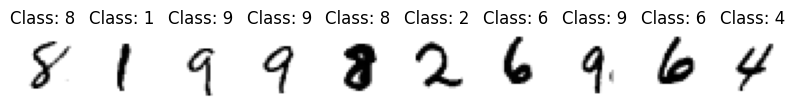

In [4]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

## MLP network definition

Let's define the network as a Python class.  We have to write the `__init__()` and `forward()` methods, and PyTorch will automatically generate a `backward()` method for computing the gradients for the backward pass.

Finally, we define an optimizer to update the model parameters based on the computed gradients.  We select *stochastic gradient descent (with momentum)* as the optimization algorithm, and set *learning rate* to 0.01.  Note that there are [several different options](http://pytorch.org/docs/optim.html#algorithms) for the optimizer in PyTorch that we could use instead of *SGD*.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)  # weight: [28*28, 50]   bias: [50, ]
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(100, 80)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(80, 10)
        
#         self.relu1 = nn.ReLU() 

    def forward(self, x):
        x = x.view(-1, 28*28)   # [32, 28*28]
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)   # [32, 10]
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=100, out_features=80, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)


## Learning

Let's now define functions to `train()` and `validate()` the model. 

In [6]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()  
        
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [7]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


Now we are ready to train our model using the `train()` function.  An *epoch* means one pass through the whole training data. After each epoch, we evaluate the model using `validate()`. 

In [8]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300761
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.091205
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.064793
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.001651
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.702526
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.662612
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.540953
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.442023
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.486407
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.513782

Validation set: Average loss: 0.3367, Accuracy: 9035/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.488707
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.424979
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.615710
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.297900
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.425904
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.478582
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.432213
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.453777
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.13

Text(0.5, 1.0, 'validation accuracy')

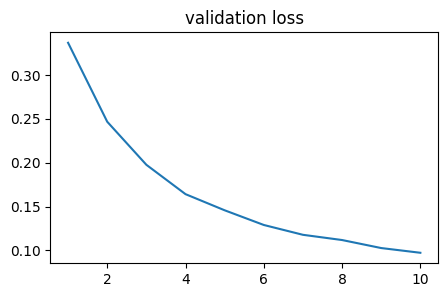

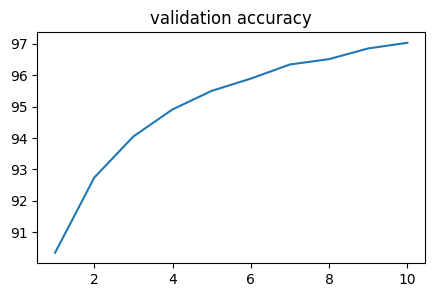

In [9]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')

In [10]:
%%time
epochs = 50

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.548564
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.092212
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.071836
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.162158
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.494614
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.124104
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.083587
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.120274
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.098112
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.057859

Validation set: Average loss: 0.0930, Accuracy: 9728/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.122966
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.170091
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.082637
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.033129
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.025734
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.065929
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.059210
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.205483
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.08

Let's now visualize how the training progressed. 

* *Loss* is a function of the difference of the network output and the target values.  We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the test data.

Text(0.5, 1.0, 'validation accuracy')

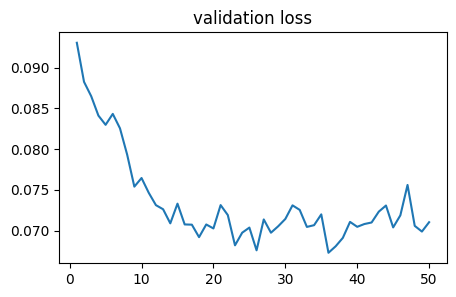

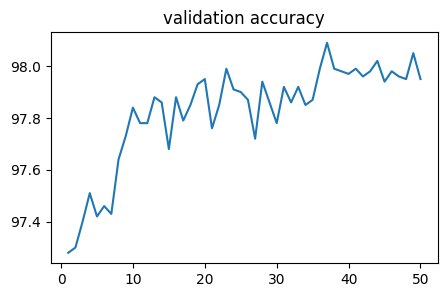

In [11]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')

## Model tuning

Modify the MLP model.  Try to improve the classification accuracy, or experiment with the effects of different parameters.  If you are interested in the state-of-the-art performance on permutation invariant MNIST, see e.g. this [recent paper](https://arxiv.org/abs/1507.02672) by Aalto University / The Curious AI Company researchers.

You can also consult the PyTorch documentation at http://pytorch.org/.

#### Method 1

out_features: 400 -> 80 -> 10

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)  # weight: [28*28, 50]   bias: [50, ]
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(400, 80)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(80, 10)
        
#         self.relu1 = nn.ReLU() 

    def forward(self, x):
        x = x.view(-1, 28*28)   # [32, 28*28]
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)   # [32, 10]
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=400, out_features=80, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.287361
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.845033
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.006465
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.610082
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.416304
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.767458
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.356157
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.480056
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.404986
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.262910

Validation set: Average loss: 0.3288, Accuracy: 9044/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.691174
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.543633
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.413090
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.302423
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.195334
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.164826
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.382477
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.423705
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.28

Text(0.5, 1.0, 'validation accuracy')

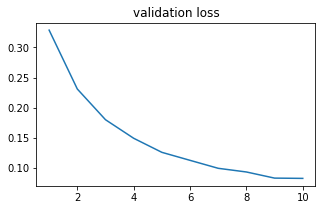

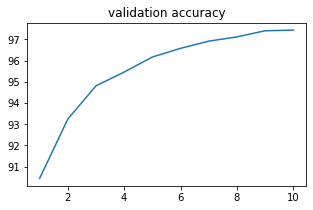

In [7]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')

#### Method 2

weight_decay = 3e-4, momentum = 0.75

In [9]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)  # weight: [28*28, 50]   bias: [50, ]
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(400, 80)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(80, 10)
        
#         self.relu1 = nn.ReLU() 

    def forward(self, x):
        x = x.view(-1, 28*28)   # [32, 28*28]
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)   # [32, 10]
        return F.log_softmax(self.fc3(x), dim=1)

model = Net2().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.75, weight_decay=3e-4)
criterion = nn.CrossEntropyLoss()

print(model)

Net2(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=400, out_features=80, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.314560
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.368521
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.490076
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.546945
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.919388
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.260408
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.390649
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.503703
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.248541
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.448023

Validation set: Average loss: 0.2327, Accuracy: 9361/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.095989
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.166534
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.301155
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.171974
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.320131
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.405735
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.240273
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.044690
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.16

Text(0.5, 1.0, 'validation accuracy')

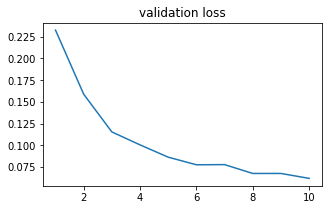

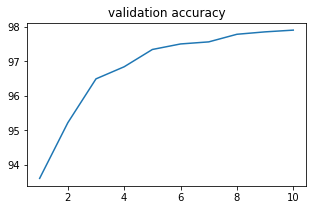

In [10]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')

#### Method 3

Another structure
out_features: 1024->512->256->128->10

In [13]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc1_drop = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc2_drop = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc3_drop = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(128, 10)
#         self.relu1 = nn.ReLU() 

    def forward(self, x):
        x = x.view(-1, 28*28)   # [32, 28*28]
        x = self.bn1(self.fc1(x))
        x = F.relu(x)
        x = self.fc1_drop(x)
        x = self.bn2(self.fc2(x))
        x = F.relu(x)
        x = self.fc2_drop(x)   # [32, 10]
        x = self.bn3(self.fc3(x))
        x = F.relu(x)
        x = self.fc3_drop(x)
        return F.log_softmax(self.fc4(x), dim=1)
        # return F.log_softmax(self.fc3(x), dim=1)

model = Net3().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5, weight_decay=3e-4)
criterion = nn.CrossEntropyLoss()

print(model)

Net3(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2_drop): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3_drop): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.395707
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.758187
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.711097
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.550592
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.512376
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.584749
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.346108
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.471188
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.210410
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.182809

Validation set: Average loss: 0.1499, Accuracy: 9549/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.351618
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.244420
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.191422
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.202751
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.119476
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.071384
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.452995
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.254748
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.37

Text(0.5, 1.0, 'validation accuracy')

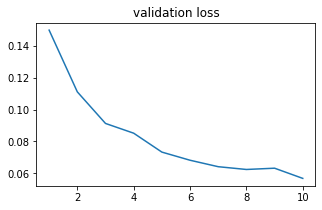

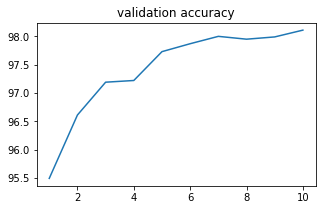

In [14]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')

#### Method 4: with all

In [12]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc1_drop = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc2_drop = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc3_drop = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(128, 10)
#         self.relu1 = nn.ReLU() 

    def forward(self, x):
        x = x.view(-1, 28*28)   # [32, 28*28]
        x = self.bn1(self.fc1(x))
        x = F.relu(x)
        x = self.fc1_drop(x)
        x = self.bn2(self.fc2(x))
        x = F.relu(x)
        x = self.fc2_drop(x)   # [32, 10]
        x = self.bn3(self.fc3(x))
        x = F.relu(x)
        x = self.fc3_drop(x)
        return F.log_softmax(self.fc4(x), dim=1)
        # return F.log_softmax(self.fc3(x), dim=1)

model = Net3().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.75, weight_decay=3e-4)
criterion = nn.CrossEntropyLoss()

print(model)

Net3(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2_drop): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3_drop): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.534846
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.678846
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.553447
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.453793
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.391807
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.424538
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.195676
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.586648
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.702217
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.430530

Validation set: Average loss: 0.1268, Accuracy: 9605/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.305924
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.105314
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.257425
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.446482
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.041106
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.197060
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.266776
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.219637
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.11

Text(0.5, 1.0, 'validation accuracy')

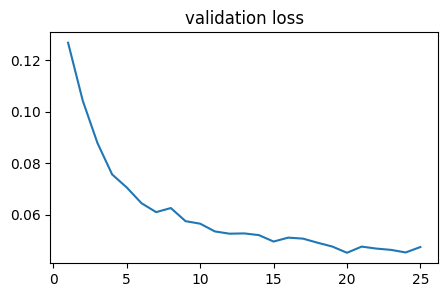

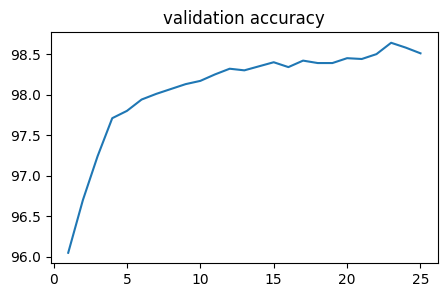

In [13]:
%%time
epochs = 25

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')